In [80]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
import pandas as pd
from IPython.display import Image
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.analytic import UpperConfidenceBound
import warnings
import gymnasium as gym
import umap
import importlib

In [139]:
import env.make
import env.eval
import env.dataset
import utils.utils as utils
importlib.reload(env.make)
importlib.reload(env.eval)
importlib.reload(env.dataset)
importlib.reload(utils);

In [140]:
%config InlineBackend.figure_format='retina'

In [142]:
DEVICE = utils.find_device(force_cpu=True)

Using device cpu


In [143]:
FIG_FOLDER, BACKUP_FOLDER = utils.make_folders()

Figures folder: ./figures
Backup folder: ./backup


# Create env and fix horizon

In [144]:
ENV = env.make.mujoco_cartpole()
TIME_HORIZON = 20

# Creating a dataset

In [145]:
train_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=1234)
test_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=12345)

Creating samples for dataset...
n=2000; avg = 0.303 +/- 0.166; range  = 0.150, 1.000
Creating samples for dataset...
n=2000; avg = 0.296 +/- 0.160; range  = 0.150, 1.000


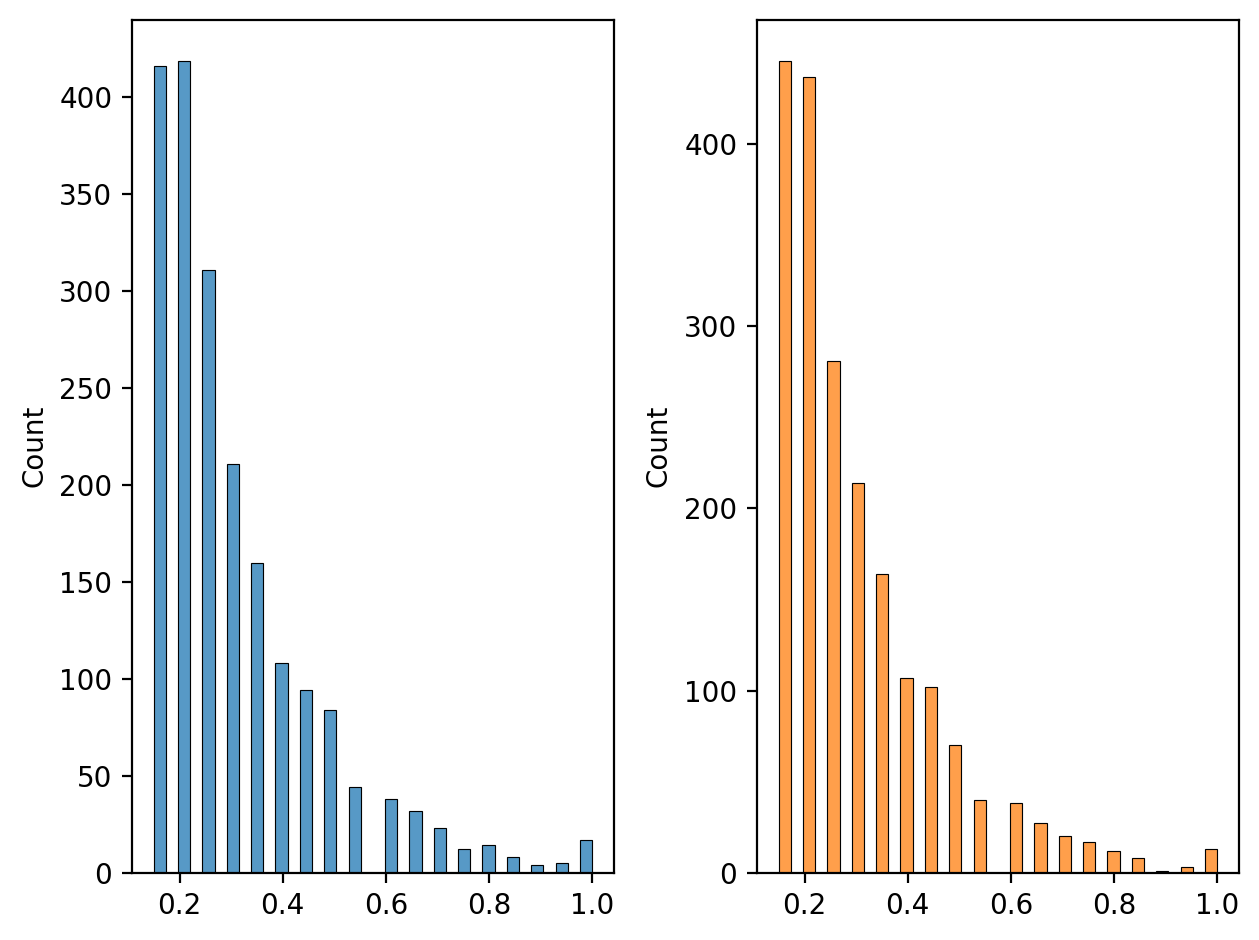

In [146]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(ax=axes[0], x=train_dataset.y.cpu().numpy())
sns.histplot(ax=axes[1], x=test_dataset.y.cpu().numpy(), color="C1")
plt.tight_layout();

# VAE

In [147]:
rnn = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [148]:
output.shape

torch.Size([5, 3, 20])

In [149]:
hn.shape

torch.Size([2, 3, 20])

In [152]:
batch_size = 2
train_loader = DataLoader(dataset=train_dataset, batch_size=64)
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.unsqueeze(-1).shape)
    break

torch.Size([64, 20, 1])


## Defining the VAE model

In [228]:
class VAE(nn.Module):
    sos_token = 2
    # https://github.com/chrisvdweth/ml-toolkit/blob/master/pytorch/models/text/autoencoder/textrnnvae.py
    def __init__(self, time_horizon, z_dim, device, hidden_dim=10, num_layers=2):
        super().__init__()

        # For encoder
        self.enc = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True)
        self.mu = nn.Linear(500, z_dim)
        self.logvar = nn.Linear(500, size_z) 
        
        self.mu = nn.Linear(hidden_dim*num_layers, z_dim)
        self.logvar = nn.Linear(hidden_dim*num_layers, z_dim)

        self.num_layers, self.hidden_dim, self.device = num_layers, hidden_dim, device
        self.time_horizon = time_horizon

        # For decoder 
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim*num_layers)

        self.out_to_seq = nn.Linear(hidden_dim, 1)
        
        self.dec = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True)
        
    def encode(self, x):
        x = x.unsqueeze(-1)
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device) 
        out, h = self.enc(x, h0)
        # (num_layers*num_directions, batch_size, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers*hidden_dim)
        h = h.transpose(0, 1).contiguous().view(batch_size, -1)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        batch_size = z.shape[0]
        h = self.z_to_hidden(z)

        # (batch_size, num_directions*num_layers*hidden_dim)    ==>
        # (batch_size, num_directions * num_layers, hidden_dim) ==>
        # (num_layers * num_directions, batch_size, hidden_dim) ==>
        h = h.view(batch_size, self.num_layers, self.hidden_dim).transpose(0, 1).contiguous()
        input = torch.zeros(batch_size, 1, 1).to(device)
        x = torch.empty((batch_size, self.time_horizon))
        for step in range(self.time_horizon):
            out, h = self.dec(input, h)
            xi = torch.sigmoid(self.out_to_seq(out.squeeze()).squeeze())
            x[:, step] = xi
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [229]:
size_z = 2
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
vae = VAE(time_horizon=TIME_HORIZON, z_dim=size_z, device=device).to(device)
for batch_idx, (x, y) in enumerate(train_loader):
    mu, logvar = vae.encode(x)
    z = vae.reparameterize(mu, logvar)
    x_rec = vae.decode(z)
    break

In [230]:
class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred = nn.Sequential(
            nn.Linear(size_z, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 1)
        )
        
    def forward(self, x):
        x = self.pred(x)
        return x.squeeze()

## Training VAE

In [231]:
def sumlogC( x , eps = 1e-5):

    # https://proceedings.neurips.cc/paper/2019/file/f82798ec8909d23e55679ee26bb26437-Paper.pdf
    # https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/notebooks/Continuous_Bernoulli.ipynb
    
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

In [241]:
def eval_reconstruction(model, data_loader):
    delta = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            mu, logvar = vae.encode(x)
            recon_x = vae.decode(mu)

        delta += torch.abs(x - recon_x).sum()
    delta /= len(data_loader)
    print(f"Avg reconstruction error: {delta.mean().item():.3f}")
    

### Random level for reconstruction

In [242]:
x = train_dataset.x
recon_x = torch.rand_like(x)
delta = torch.abs(x - recon_x)
print(f"Avg reconstruction error: {delta.mean().item():.3f} +/- {delta.std().item():.3f}")

Avg reconstruction error: 0.336 +/- 0.236


### Training loop

In [243]:
seed = 1234
size_z = 2
lr = 0.001
batch_size = 64 #len(train_dataset.y)
n_epoch = 1000

torch.manual_seed(seed)

vae = VAE(time_horizon=TIME_HORIZON, z_dim=size_z, device=DEVICE).to(DEVICE)
reg = Regression(size_z).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

eval_reconstruction(vae, train_loader)
eval_reconstruction(vae, test_loader)

optimizer = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=lr)

hist_vae_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        vae_loss = 0 
        vae_rec_abs_err = 0
        reg_loss = 0
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            # https://arxiv.org/abs/1312.6114
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            # https://proceedings.neurips.cc/paper/2019/file/f82798ec8909d23e55679ee26bb26437-Paper.pdf
            # https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/notebooks/Continuous_Bernoulli.ipynb
            logc = sumlogC(recon_x)
            l_vae = bce + 0.01*kl + logc 
            
            pred = reg(mu)
            l_reg = nn.MSELoss(reduction="sum")(target=y, input=pred)

            loss = l_vae + 0.001*l_reg
            
            loss.backward()
            optimizer.step()

            vae_loss += l_vae.item()
            vae_rec_abs_err += (recon_x - x).abs().sum()
            reg_loss += l_reg.item()

        hist_vae_loss.append(vae_loss/len(y))
        # if epoch > 0 and epoch % 50 == 0:
        pbar.update()
        pbar.set_postfix({
            "loss VAE": f"{vae_loss/len(y):.4f}",
            "rec Error": f"{vae_rec_abs_err/(len(y)*TIME_HORIZON):.3f}",
            "loss regression": f"{reg_loss/len(y):.4f}"
        })

eval_reconstruction(vae, train_dataset)
eval_reconstruction(vae, test_dataset)

Avg reconstruction error: 2.462
Avg reconstruction error: 2.603


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Visualize structuration of the latent space

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    mu, logvar = vae.encode(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    mu, logvar = vae.encode(x)
    z = mu
    x_rec = vae.decode(z)
    y_rec = eval_trajectories(x_rec)

all_y = torch.cat([y, y_rec])
vmin, vmax = all_y.min(), all_y.max()

z = z.cpu().numpy()
y_rec = y_rec.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y_rec,
    cmap="viridis",
    vmin=vmin, vmax=vmax,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

x_lim = min(z[:, 0]), max(z[:, 0]) 
y_lim = min(z[:, 1]), max(z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

# im = plt.contourf(gx, gy, gz, cmap='viridis')
fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) # vmin=0.0, vmax=1.0)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    dataset_z = mu.cpu().numpy()
    dataset_y = y.cpu().numpy()

x_lim = min(dataset_z[:, 0]), max(dataset_z[:, 0]) 
y_lim = min(dataset_z[:, 1]), max(dataset_z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    print(x.shape)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
ax.scatter(
    dataset_z[:, 0], dataset_z[:, 1], 
    c=dataset_y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)


fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_x, mu, logvar = vae(x)
    dataset_z = mu.cpu().numpy()
    x_prime = vae.decode(mu)
    x_prime = x_prime.cpu().numpy() 
    y = np.zeros(len(x_prime))
    for i in range(len(x_prime)):
        y[i] = eval_trajectory(trajectory=x_prime[i]) / TIME_HORIZON
    
    dataset_y = y

x_lim = min(dataset_z[:, 0]), max(dataset_z[:, 0]) 
y_lim = min(dataset_z[:, 1]), max(dataset_z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
ax.scatter(
    dataset_z[:, 0], dataset_z[:, 1], 
    c=dataset_y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)


fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

## Same thing but using the regressor from the latent

In [ ]:
vae.eval()
rx, ry = np.linspace(*x_lim, 20), np.linspace(*y_lim, 20)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()

    y = reg(z)
    
    # x = x.cpu().numpy()
    y = y.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz)  #, vmin=0.0, vmax=1.0);

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(gx, gy, gz) #, #vmin=0.0, vmax=1.0)

vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=3.0)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

# Using GP after VAE trained

In [ ]:
n_sample_start = 40

# Create a small dataset from the dataset the VAE has been trained with
best = torch.topk(train_dataset.y, k=n_sample_start).indices
train_x = train_dataset.x[best]
train_y = train_dataset.y[best]

# best_reward = train_y.max()
# train_y /= best_reward


with torch.no_grad():
    vae.eval()
    train_z, _ = vae.encode(train_dataset.x[best])

train_x = train_x.double()
train_y = train_y.double()
train_z = train_z.double()

fig, ax = plt.subplots()
ax.scatter(
    x=train_z[:, 0].numpy(), 
    y=train_z[:, 1].numpy(), 
    c=train_y.numpy(),  
    cmap="viridis");

In [ ]:


x_lim = -4, 4 
y_lim = -4, 4

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
plt.colorbar(im);

In [ ]:
bounds = torch.tensor([[-4.0] * size_z, [4.0] * size_z]).to(device)

n_sample_start = 500

# Create a small dataset from the dataset the VAE has been trained with
train_z = unnormalize(torch.rand(n_sample_start, size_z, device=device, dtype=dtype), bounds=bounds)


# best_reward = train_y.max()
# train_y /= best_reward


with torch.no_grad():
    vae.eval()
    train_x = vae.decode(train_z)
    train_y = torch.tensor([eval_trajectory(traj.cpu().numpy()) for traj in train_x]) / TIME_HORIZON

train_x = train_x.double()
train_y = train_y.double()
train_z = train_z.double()

fig, ax = plt.subplots()
im = ax.scatter(
    x=train_z[:, 0].numpy(), 
    y=train_z[:, 1].numpy(), 
    c=train_y.numpy(),  
    cmap="viridis")
plt.colorbar(im);

In [ ]:
torch.manual_seed(1234)

dtype=torch.float

acq_opt__batch_size = 20
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 123

n_batch = 20

best_observed = []
cand_observed = []
val_observed = []

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # bound = torch.max(torch.tensor([-train_z.min(), train_z.max()]))

        # fit the GP model
        # normalize(train_h, bounds=bounds), 
        # standardize(train_obj) 
        normalized_train_z = normalize(train_z, bounds=bounds)
        standardized_train_y = standardize(train_y.unsqueeze(dim=1))
        # print(normalized_train_z)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = SingleTaskGP(train_X=normalized_train_z, train_Y=standardized_train_y)
        # if state_dict is not None:
        #     model.load_state_dict(state_dict)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        mll.to(device)
        fit_gpytorch_mll(mll)

        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(
            sample_shape=qmc_sampler__sample_shape,
            seed=qmc_sampler__seed)
        acq_f = qExpectedImprovement(
            model=model, 
            sampler=qmc_sampler, 
            best_f=train_y.max())
        # acq_f = UpperConfidenceBound(model=model, beta=0.2)
        # optimize and get new observation
        # optimize
        candidates, _ = optimize_acqf(
            acq_function=acq_f,
            bounds=bounds,
            q=acq_opt__batch_size,
            num_restarts=acq_opt__num_restarts,
            raw_samples=acq_opt__raw_samples,
        )

        # observe new values 
        with torch.no_grad():
            new_z = unnormalize(candidates.detach(), bounds=bounds)
            new_x = vae.decode(new_z)
            new_y = torch.tensor([eval_trajectory(traj.cpu().numpy()) for traj in new_x]) / TIME_HORIZON

        # update training points
        train_z = torch.cat((train_z, new_z))
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)
        for z, y in zip(new_z, new_y):
            cand_observed.append(z.numpy().tolist())
            val_observed.append(y.item())

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix({"best": f"{best_value:.2f}"})

In [ ]:
fig, ax = plt.subplots()
ax.plot(best_observed);

In [ ]:
cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed).squeeze()

s = np.repeat(np.linspace(1, 10, n_batch)**2, acq_opt__batch_size)
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

fig, ax = plt.subplots()
im = ax.scatter(x=x, y=y, c=c, s=s, cmap="viridis")
plt.colorbar(im);

In [ ]:
vae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

x_lim = min(z[:, 0]), max(z[:, 0]) 
y_lim = min(z[:, 1]), max(z[:, 1]) 

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)
    print(x.shape)
    y = np.zeros(len(x))
    for i in range(len(x)):
        traj = x[i].cpu().numpy()
        val = eval_trajectory(trajectory=traj) / TIME_HORIZON
        y[i] = val
    
    x = x.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

# im = plt.contourf(gx, gy, gz, cmap='viridis')
fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz)  #, vmin=0.0, vmax=1.0)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]));

cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed).squeeze()

s = np.repeat(np.linspace(1, 10, n_batch)**2, acq_opt__batch_size)
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

ax.scatter(x=x, y=y, c=c, s=s, cmap="viridis");

In [ ]:
s = np.linspace(10, 50, len(val_observed))
x = cand_observed[:, 0]
y = cand_observed[:, 1]
c = val_observed

In [ ]:
print(c.shape, s.shape, x.shape, y.shape)

In [ ]:
np.repeat([1, 2, 3], 3)

In [ ]:
x_lim = -40, 40
y_lim = -40, 40

grid_size = 40

vae.eval()
rx, ry = np.linspace(*x_lim, grid_size), np.linspace(*y_lim, grid_size)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    x = x.cpu().numpy()
    z = z.cpu().numpy()
    
    y = np.zeros(len(x))
    for i in tqdm(range(len(x))):
        y[i] = eval_trajectory(trajectory=x[i]) / TIME_HORIZON

gz = y.reshape(gx.shape)

fig, ax = plt.subplots()
im = ax.pcolormesh(gx, gy, gz) #, vmin=0.0, vmax=1.0)
plt.colorbar(im);